##### Image Generation with GANs

In [2]:
import torch, torchvision, torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os, pickle, math, random
from copy import deepcopy
device ='cuda' if torch.cuda.is_available() else 'cpu'
torch.__version__, torchvision.__version__

('2.5.1+cu124', '0.20.1+cu124')

In [ ]:
''' Reverse engineering steps in discriminator work, recap of 2D convolutional
operator works on an image, 2D transposed convolutional operation, building
and traiining GANs to generate color images '''

In [83]:
torch.manual_seed(42)
transform=T.Compose(
    [T.Resize((224, 224)),
     T.ToTensor(),
     T.Normalize(mean=[0.485,0.456, 0.406], std = [0.229, 0.224, 0.225])
])

train_set = torchvision.datasets.Country211(
    root = '.', split='train', download=True, transform=transform )
test_set = torchvision.datasets.Country211(
    root = '.', split='test', download=True, transform=transform )
validation_set = test_set = torchvision.datasets.Country211(
    root = '.', split='valid', download=True, transform=transform )

batch_size = 64
dataloader_train = DataLoader(train_set, batch_size, shuffle=True)
dataloader_test = DataLoader(test_set, batch_size, shuffle=False)
dataloader_validation = DataLoader(validation_set, batch_size, shuffle=False)

In [84]:
''' Discriminator Binary Classifier '''
Discriminator = nn.Sequential(
    nn.Linear(3*224*224, 5120),
    nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(5120, 1024),
    nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()).to(device)

Generator = nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 5120),
    nn.ReLU(),
    nn.Linear(5120, 3*224*224),
    nn.Tanh()).to(device)

loss_fn = nn.BCELoss()
lr = 0.0001
optim_d = torch.optim.Adam(Discriminator.parameters(), lr=lr)
optim_g = torch.optim.Adam(Generator.parameters(), lr=lr)

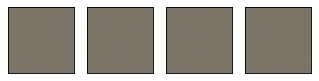

In [85]:
def visualize():
  noise = torch.randn(85, 100).to(device)
  samples_fake = Generator(noise).cpu().detach()
  plt.figure(dpi=80, figsize=(10,5))
  for i in range(4):
    ax = plt.subplot(4, 8, i +1)
    images = (samples_fake[i]).reshape(3, 224,224)
    images  = images.numpy().transpose(1,2,0)
    images = images *[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    plt.imshow(images)
    plt.xticks([]) ; plt.yticks([])
  plt.show()
visualize()

In [65]:
scripted = torch.jit.script(Generator)
os.makedirs('file-samples', exist_ok=True)
scripted.save('file-samples/country211_gen.pt')
new_generator = torch.jit.load('file-samples/country211_gen.pt', map_location=device)
new_generator.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
  (5): RecursiveScriptModule(original_name=ReLU)
  (6): RecursiveScriptModule(original_name=Linear)
  (7): RecursiveScriptModule(original_name=ReLU)
  (8): RecursiveScriptModule(original_name=Linear)
  (9): RecursiveScriptModule(original_name=Tanh)
)

In [81]:
device='cpu'

In [ ]:
def train_discriminator_onreal(samples_real):
  r_ = samples_real.reshape(-1, 3*224*224).to(device)
  out_ = Discriminator(r_)
  labels_ = torch.ones((r_.shape[0], 1)).to(device)
  loss_discriminator = loss_fn(out_, labels_)
  optim_d.zero_grad()
  loss_discriminator.backward()
  optim_d.step()
  return loss_discriminator

def train_discriminator_onfake():
  noise = torch.randn((batch_size, 100)).to(device)
  generated_data = Generator(noise)
  predictions = Discriminator(generated_data)
  loss_discriminator = loss_fn(predictions, labels_fake)
  optim_d.zero_grad()
  loss_discriminator.backward()
  optim_d.step()
  return loss_discriminator

def train_generator():
  noise = torch.randn((batch_size, 100)).to(device)
  generated_data  = Generator(noise)
  predictions = Discriminator(generated_data)
  loss_generator = loss_fn(predictions, labels_real)
  optim_g.zero_grad()
  loss_generator.backward()
  optim_g.step()
  return loss_generator

labels_real = torch.ones((batch_size, 1)).to(device)
labels_fake = torch.ones((batch_size, 1)).to(device)

for i in range(2):
  gloss, dloss = 0, 0
  for n, (real_samples, _ ) in enumerate(dataloader_train):
    loss_discriminator = train_discriminator_onreal(real_samples)
    dloss += loss_discriminator
    loss_discriminator = train_discriminator_onfake()
    dloss += loss_discriminator
    loss_generator = train_generator()
    gloss += loss_generator
  gloss /= n
  dloss /= n
  if i % 10 ==9:
    print(f'at epoch {i+1}, dloss {dloss}, gloss {gloss}')
    visualize()

In [ ]:
noise = torch.randn(batch_size, 100).to(device)
samples_fake = Generator(noise).cpu().detach()
plt.figure(dpi=80, figsize=(10,5))

for i in range(4):
    ax = plt.subplot(4, 8, i +1)
    images = (samples_fake[i]).reshape(3, 224,224)
    images  = images.numpy().transpose(1,2,0)
    images = images *[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    plt.imshow(images)
    plt.xticks([]) ; plt.yticks([])
plt.show()


In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)